# Extract Intrinsic Currents from Raw ABF files of Voltage Steps

In [1]:
import pyabf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import auc


## Read in the data

In [2]:
dir_in = r'\Projects\All Olive\Intrinsic\ABF\'
#dir_in = dir_in.replace (r'\', r'\\\')
file_in = '2019_08_08_0018.abf'
dir_out = dir_in + '\\Analyzed'

os.chdir (dir_in)
abf = pyabf.ABF(file_in)

## Function Definitions

## Set up the data frame

In [3]:
columns = {'filename':[], 'vstep':[], 'baseline':[],'h_peak':[],'ss_peak':[],'ahp_peak':[],'ca_peak':[],'i_h':[],'i_ahp':[],'i_ca':[],'i_input':[],'r_input':[]}

channels = [0,2]
sweep_list = abf.sweepList # Get all sweeps in the file
step_list = list([-55, -45, -35, -25, -15, -5, 5, 15, 25, 35, 45, 55])



## Analyze the raw traces for relevant peaks for Ch1

,filename,vstep,baseline,i_ss,i_h,i_ahp,i_ca,r_input,h_peak,ss_peak,ahp_peak,ca_peak,i_input
0,2019_08_08_0018.abf,-55.0,-47.492676,-231.740143,-2.139252,37.727051,-232.658691,237.334798,-281.372070,-279.232819,-9.765625,-280.151367,-231.740143
0,2019_08_08_0018.abf,-45.0,-55.115971,-183.106689,-1.645508,36.195072,-182.921143,245.758362,-239.868164,-238.222656,-18.920898,-238.037109,-183.106689
0,2019_08_08_0018.abf,-35.0,-115.291748,-71.188354,0.322876,101.253662,-78.189697,491.653449,-186.157227,-186.480103,-14.038086,-193.481445,-71.188354
0,2019_08_08_0018.abf,-25.0,-50.209961,-90.114136,-0.667114,11.147461,-90.781250,277.425953,-140.991211,-140.324097,-39.062500,-140.991211,-90.114136
0,2019_08_08_0018.abf,-15.0,-56.231686,-44.243778,-0.842896,4.962154,-48.138432,339.030720,-101.318359,-100.475464,-51.269531,-104.370117,-44.243778
0,2019_08_08_0018.abf,-5.0,-62.366947,12.844852,-13.954468,5.604252,3.162846,-389.260992,-63.476562,-49.522095,-56.762695,-59.204102,12.844852
0,2019_08_08_0018.abf,5.0,-63.043209,41.129147,46.328125,6.280514,-67.572021,121.568290,24.414062,-21.914062,-56.762695,-130.615234,41.129147
0,2019_08_08_0018.abf,15.0,-59.052734,89.548950,94.015503,36.469727,-45.927734,167.506151,124.511719,30.496214,-22.583008,-104.980469,89.548950
0,2019_08_08_0018.abf,25.0,-56.580814,197.955917,63.092667,50.477299,-376.158447,126.290744,204.467773,141.375107,-6.103516,-432.739258,197.955917
0,2019_08_08_0018.abf,35.0,-49.968262,267.472534,68.750595,32.268066,-145.344238,130.854557,286.254883,217.504288,-17.700195,-195.312500,267.472534


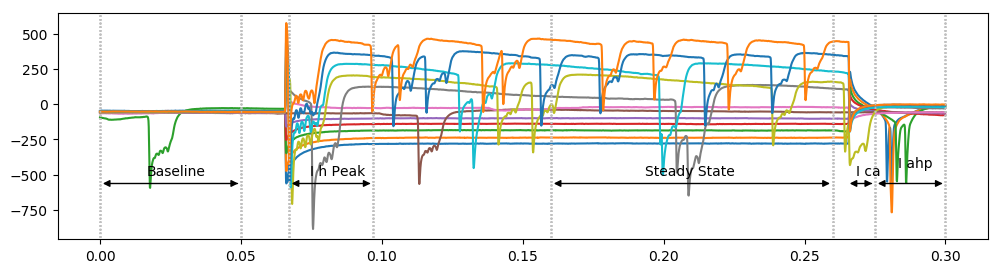

In [4]:
channel = 0
x1 = np.nan
x2 = np.nan
y1 = np.nan
y2 = np.nan

baseline_start = 0 * abf.dataPointsPerMs 
baseline_end = 50 * abf.dataPointsPerMs 
h_start = 67  * abf.dataPointsPerMs 
h_end = 97  * abf.dataPointsPerMs
ss_start = 160 * abf.dataPointsPerMs 
ss_end = 260  * abf.dataPointsPerMs 
ahp_start = 275 * abf.dataPointsPerMs 
ahp_end = 300  * abf.dataPointsPerMs 
ca_start = 265 * abf.dataPointsPerMs 
ca_end = 275 * abf.dataPointsPerMs 
        
df = pd.DataFrame.from_dict (columns)   
file_out = file_in.replace('.abf','') + '_Ch_' + str(channel) + '.csv' 
i = 0
fig, ax = plt.subplots(1,1, figsize=(12, 3), dpi = 100)
for sweep in sweep_list:
    
    filename = file_in
    vstep = step_list[i]
    abf.setSweep (sweepNumber = sweep, channel = channel)    
    x = abf.sweepX[baseline_start:ahp_end]
    y = abf.sweepY[baseline_start:ahp_end]
    x_min = min(x)
    x_max = max(x)
    y_min = min (y)
    y_max = max(y)
    
    
    sf = abf.dataPointsPerMs  *1000 # scale factor for referencing time on the plotted data (points/sec)
    baseline = np.average (abf.sweepY [baseline_start: baseline_end])
    h_peak = np.max (abf.sweepY [h_start: h_end])
    ss_peak = np.average (abf.sweepY [ss_start: ss_end])
    ahp_peak = np.max (abf.sweepY [ahp_start: ahp_end])
    ca_peak = np.min (abf.sweepY [ca_start: ca_end])
    
    i_ss = ss_peak - baseline
    i_h = h_peak - ss_peak
    i_ahp = ahp_peak - baseline
    i_ca = ca_peak - baseline
    i_input = ss_peak - baseline
    r_input = vstep/i_input * 1000
    df = df.append ([{'filename':filename, 'vstep':vstep, 'baseline':baseline, 'h_peak':h_peak, 
                          'ss_peak':ss_peak, 'ahp_peak':ahp_peak, 'ca_peak':ca_peak, 'i_ss':i_ss,'i_h':i_h,'i_ahp':i_ahp, 
                          'i_ca':i_ca, 'i_input':i_input, 'r_input': r_input}], sort = False)
    df = df[['filename', 'vstep', 'baseline', 'i_ss','i_h','i_ahp','i_ca', 'r_input', 'h_peak', 'ss_peak', 'ahp_peak',
        'ca_peak', 'i_input']]
    
    ax.plot (x, y, linestyle = 'solid')
      
    ax.axvline(baseline_start/sf, y_min, y_max, color = 'silver', lw = 1, linestyle = ':')
    ax.axvline(baseline_end/sf  , y_min, y_max , color = 'silver', lw = 1, linestyle = ':')
    ax.axvline(h_start/sf, y_min, y_max , color = 'silver', lw = 1, linestyle = ':')
    ax.axvline(h_end/sf, y_min, y_max, color = 'silver', lw = 1, linestyle = ':')
    ax.axvline(ahp_start/sf, y_min, y_max , color = 'silver', lw = 1, linestyle = ':')
    ax.axvline(ahp_end/sf, y_min, y_max , color = 'silver', lw = 1, linestyle = ':')
    ax.axvline(ss_start/sf,y_min, y_max , color = 'silver', lw = 1, linestyle = ':')
    ax.axvline(ss_end/sf, y_min, y_max , color = 'silver', lw = 1, linestyle = ':')
        
    if i == 0:
        ax.annotate('Baseline', xy=((baseline_end/sf - baseline_start/sf)/3, y_min - y_min *0.1), color = 'black') 
        ax.annotate('', xy=(baseline_start/sf, y_min), xytext = (baseline_end/sf, y_min), arrowprops=dict(arrowstyle="<|-|>", connectionstyle = "bar, fraction = 0", color = 'black'))
        ax.annotate('I h Peak', xy=(h_start/sf + (h_end/sf - h_start/sf)/4, y_min - y_min *0.1)) 
        ax.annotate('', xy=(h_start/sf, y_min), xytext = (h_end/sf, y_min), arrowprops=dict(arrowstyle="<|-|>", connectionstyle = "bar, fraction = 0", color = 'black'))
        ax.annotate('Steady State', xy=(ss_start/sf + (ss_end/sf - ss_start/sf)/3, y_min - y_min *0.1)) 
        ax.annotate('', xy=(ss_start/sf, y_min), xytext = (ss_end/sf, y_min), arrowprops=dict(arrowstyle="<|-|>", connectionstyle = "bar, fraction = 0", color = 'black'))
        ax.annotate('I ahp', xy=(ahp_start/sf + (ahp_end/sf - ahp_start/sf)/3, y_min - y_min *0.2)) 
        ax.annotate('I ca', xy=(ca_start/sf + (ca_end/sf - ca_start/sf)/3, y_min - y_min *0.1)) 
        ax.annotate('', xy=(ahp_start/sf, y_min), xytext = (ahp_end/sf, y_min), arrowprops=dict(arrowstyle="<|-|>", connectionstyle = "bar, fraction = 0", color = 'black'))
        ax.annotate('', xy=(ca_start/sf, y_min), xytext = (ca_end/sf, y_min), arrowprops=dict(arrowstyle="<|-|>", connectionstyle = "bar, fraction = 0", color = 'black'))

        
    i = i + 1
    
display(HTML(df.to_html()))
    
try:
    os.stat(dir_out)
except:
    os.makedirs(dir_out)
    
# Write data to file
os.chdir(dir_out)
df.to_csv(file_out, index = False)
       


,filename,vstep,baseline,i_ss,i_h,i_ahp,i_ca,r_input,h_peak,ss_peak,ahp_peak,ca_peak,i_input
0,2019_08_08_0018.abf,-55.0,-115.330811,-424.971924,9.296875,41.478271,-412.012939,129.420314,-531.005859,-540.302734,-73.852539,-527.343750,-424.971924
0,2019_08_08_0018.abf,-45.0,-132.708755,-312.553101,3.367310,51.531998,-314.068604,143.975535,-441.894531,-445.261841,-81.176758,-446.777344,-312.553101
0,2019_08_08_0018.abf,-35.0,-124.503174,-240.390625,-1.317139,31.119385,-241.097412,145.596360,-366.210938,-364.893799,-93.383789,-365.600586,-240.390625
0,2019_08_08_0018.abf,-25.0,-128.389893,-160.430908,1.345215,6.319580,-167.630615,155.830321,-287.475586,-288.820801,-122.070312,-296.020508,-160.430908
0,2019_08_08_0018.abf,-15.0,-129.107666,-77.280884,2.531128,8.258057,-77.191162,194.097159,-203.857422,-206.388550,-120.849609,-206.298828,-77.280884
0,2019_08_08_0018.abf,-5.0,-131.198715,-2.096573,3.290405,3.635239,-3.688980,2384.844361,-130.004883,-133.295288,-127.563477,-134.887695,-2.096573
0,2019_08_08_0018.abf,5.0,-129.313965,74.451904,95.755615,7.243652,-111.164551,67.157449,40.893555,-54.862064,-122.070312,-240.478516,74.451904
0,2019_08_08_0018.abf,15.0,-123.459480,148.177490,184.022217,6.882332,-217.116699,101.229950,208.740234,24.718018,-116.577148,-340.576172,148.177490
0,2019_08_08_0018.abf,25.0,-126.859131,261.363525,251.237778,13.944092,-324.190674,95.652215,385.742188,134.504410,-112.915039,-451.049805,261.363525
0,2019_08_08_0018.abf,35.0,-126.121826,388.782959,294.589844,50.438232,-288.917236,90.024522,557.250977,262.661133,-75.683594,-415.039062,388.782959


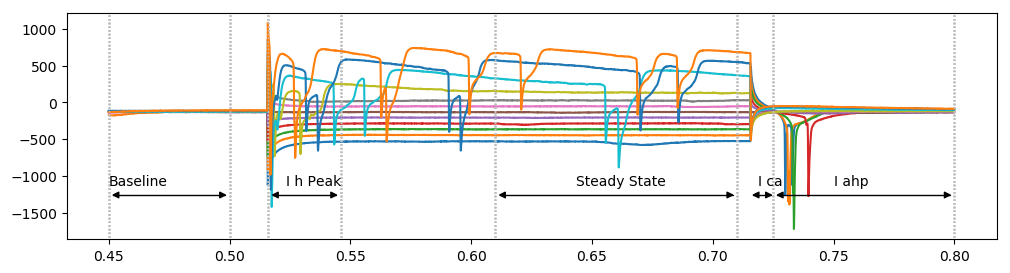

In [5]:
channel = 2
x1 = np.nan
x2 = np.nan
y1 = np.nan
y2 = np.nan

baseline_start = 450  * abf.dataPointsPerMs
baseline_end = 500  * abf.dataPointsPerMs 
h_start = 516 * abf.dataPointsPerMs 
h_end =  546 * abf.dataPointsPerMs
ss_start =  610 * abf.dataPointsPerMs
ss_end = 710  * abf.dataPointsPerMs
ahp_start =  725 * abf.dataPointsPerMs
ahp_end = 800  * abf.dataPointsPerMs
ca_start = 715 * abf.dataPointsPerMs
ca_end = 726* abf.dataPointsPerMs
        
df = pd.DataFrame.from_dict (columns)   
file_out = file_in.replace('.abf','') + '_Ch_' + str(channel) + '.csv' 
i = 0
fig, ax = plt.subplots(1,1, figsize=(12, 3), dpi = 100)
for sweep in sweep_list:
    filename = file_in
    vstep = step_list[i]
    abf.setSweep (sweepNumber = sweep, channel = channel)    
    x = abf.sweepX[baseline_start:ahp_end]
    y = abf.sweepY[baseline_start:ahp_end]
    x_min = min(x)
    x_max = max(x)
    y_min = min (y)
    y_max = max(y)
    sf = abf.dataPointsPerMs  *1000 # scale factor for referencing time on the plotted data (points/sec)
    baseline = np.average (abf.sweepY [baseline_start: baseline_end])
    h_peak = np.max (abf.sweepY [h_start: h_end])
    ss_peak = np.average (abf.sweepY [ss_start: ss_end])
    ahp_peak = np.max (abf.sweepY [ahp_start: ahp_end])
    ca_peak = np.min (abf.sweepY [ca_start: ca_end])
    
    i_ss = ss_peak - baseline
    i_h = h_peak - ss_peak
    i_ahp = ahp_peak - baseline
    i_ca = ca_peak - baseline
    i_input = ss_peak - baseline
    r_input = vstep/i_input * 1000
    df = df.append ([{'filename':filename, 'vstep':vstep, 'baseline':baseline, 'h_peak':h_peak, 
                          'ss_peak':ss_peak, 'ahp_peak':ahp_peak, 'ca_peak':ca_peak, 'i_ss':i_ss,'i_h':i_h,'i_ahp':i_ahp, 
                          'i_ca':i_ca, 'i_input':i_input, 'r_input': r_input}], sort = False)
    df = df[['filename', 'vstep', 'baseline', 'i_ss','i_h','i_ahp','i_ca', 'r_input', 'h_peak', 'ss_peak', 'ahp_peak',
        'ca_peak', 'i_input']]
    
    
    ax.plot (x, y, linestyle = 'solid')
  
    ax.axvline(baseline_start/sf, y_min, y_max, color = 'silver', lw = 1, linestyle = ':')
    ax.axvline(baseline_end/sf  , y_min, y_max , color = 'silver', lw = 1, linestyle = ':')
    ax.axvline(h_start/sf, y_min, y_max , color = 'silver', lw = 1, linestyle = ':')
    ax.axvline(h_end/sf, y_min, y_max, color = 'silver', lw = 1, linestyle = ':')
    ax.axvline(ahp_start/sf, y_min, y_max , color = 'silver', lw = 1, linestyle = ':')
    ax.axvline(ahp_end/sf, y_min, y_max , color = 'silver', lw = 1, linestyle = ':')
    ax.axvline(ss_start/sf,y_min, y_max , color = 'silver', lw = 1, linestyle = ':')
    ax.axvline(ss_end/sf, y_min, y_max , color = 'silver', lw = 1, linestyle = ':')
        
    if i == 0:
        ax.annotate('Baseline', xy=(baseline_start/sf, y_min - y_min *0.1), color = 'black') 
        ax.annotate('', xy=(baseline_start/sf, y_min), xytext = (baseline_end/sf, y_min), arrowprops=dict(arrowstyle="<|-|>", connectionstyle = "bar, fraction = 0", color = 'black'))
        ax.annotate('I h Peak', xy=(h_start/sf + (h_end/sf - h_start/sf)/4, y_min - y_min *0.1)) 
        ax.annotate('', xy=(h_start/sf, y_min), xytext = (h_end/sf, y_min), arrowprops=dict(arrowstyle="<|-|>", connectionstyle = "bar, fraction = 0", color = 'black'))
        ax.annotate('Steady State', xy=(ss_start/sf + (ss_end/sf - ss_start/sf)/3, y_min - y_min *0.1)) 
        ax.annotate('', xy=(ss_start/sf, y_min), xytext = (ss_end/sf, y_min), arrowprops=dict(arrowstyle="<|-|>", connectionstyle = "bar, fraction = 0", color = 'black'))
        ax.annotate('I ahp', xy=(ahp_start/sf + (ahp_end/sf - ahp_start/sf)/3, y_min - y_min *0.1)) 
        ax.annotate('I ca', xy=(ca_start/sf + (ca_end/sf - ca_start/sf)/3, y_min - y_min *0.1)) 
        ax.annotate('', xy=(ahp_start/sf, y_min), xytext = (ahp_end/sf, y_min), arrowprops=dict(arrowstyle="<|-|>", connectionstyle = "bar, fraction = 0", color = 'black'))
        ax.annotate('', xy=(ca_start/sf, y_min), xytext = (ca_end/sf, y_min), arrowprops=dict(arrowstyle="<|-|>", connectionstyle = "bar, fraction = 0", color = 'black'))

        
    i = i + 1
    
display(HTML(df.to_html()))
   
try:
    os.stat(dir_out)
except:
    os.makedirs(dir_out)
    
# Write data to file
os.chdir(dir_out)
df.to_csv(file_out, index = False)
       

